# Dataset: 
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Flatten, Bidirectional, Activation
from collections import Counter

In [125]:
df = pd.read_csv("household_power_consumption.txt", delimiter=';', low_memory=False, nrows=100000)

In [126]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data taken each minute, date not needed

### In case date is needed

In [127]:
# df['Datetime']=df['Date']+' '+ df['Time']
# pd.to_datetime(df.Datetime);
# df.set_index('Datetime', inplace=True)

In [128]:
df.drop(['Time','Date'], axis=1, inplace=True)

In [129]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Check for nan 

In [130]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           8
dtype: int64

## For training purposes ,  rows with nan values are deleted

In [131]:
df.dropna(axis=0,how='any', inplace=True)

In [132]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [133]:
# df = df[['Global_reactive_power','Voltage','Global_intensity',
#          'Sub_metering_1','Sub_metering_2','Sub_metering_3','Global_active_power']]

In [134]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Check data type and convert

In [135]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [136]:
# df.reset_index(drop=True, inplace=True)

In [137]:
df = df.astype('float64') 

In [138]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247314,-0.633190,0.998928,0.418881,0.430774,0.544368
Global_reactive_power,0.247314,1.000000,-0.160869,0.258904,0.109491,0.172522,0.091150
Voltage,-0.633190,-0.160869,1.000000,-0.639747,-0.239636,-0.218631,-0.420529
Global_intensity,0.998928,0.258904,-0.639747,1.000000,0.422960,0.436023,0.534891
Sub_metering_1,0.418881,0.109491,-0.239636,0.422960,1.000000,0.062960,0.116243
Sub_metering_2,0.430774,0.172522,-0.218631,0.436023,0.062960,1.000000,0.118911
Sub_metering_3,0.544368,0.091150,-0.420529,0.534891,0.116243,0.118911,1.000000


## Column "Global_intensity" 0,998 Linear relationship with the output "Global_active_power", for training purposes this column isnt droped

## Data split (train, target)

In [139]:
train = df[['Global_reactive_power','Voltage','Global_intensity',
            'Sub_metering_1','Sub_metering_2','Sub_metering_3']].copy(deep=True)

In [140]:
test = df['Global_active_power'].copy(deep=True)

In [141]:
train.dtypes

Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [142]:
train.isnull().sum()

Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [143]:
train.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.418,234.84,18.4,0.0,1.0,17.0
1,0.436,233.63,23.0,0.0,1.0,16.0
2,0.498,233.29,23.0,0.0,2.0,17.0
3,0.502,233.74,23.0,0.0,1.0,17.0
4,0.528,235.68,15.8,0.0,1.0,17.0


In [144]:
train.shape

(99992, 6)

In [145]:
test.shape

(99992,)

## Data split for training and for eval

In [147]:
x_train_data = train.head(89992)
y_train_data = test.head(89992)

x_test_data=train.tail(10000)
y_test_data=test.tail(10000)

# x_train_data = train.head(8998)
# y_train_data = test.head(8998)

# x_test_data=train.tail(1000)
# y_test_data=test.tail(1000)

In [148]:
x_train_data.shape

(89992, 6)

In [149]:
y_train_data.shape

(89992,)

In [150]:
x_test_data.shape

(10000, 6)

In [151]:
y_test_data.shape

(10000,)

In [152]:
x_train_data.shape[0]

89992

## Numpy array conversion and data normalization

In [153]:
x_train_data=np.array(x_train_data)
x_train_data=x_train_data.reshape(x_train_data.shape[0],6)

x_test_data=np.array(x_test_data)
x_test_data=x_test_data.reshape(x_test_data.shape[0],6)

In [154]:
y_train_data=np.array(y_train_data)
y_train_data=y_train_data.reshape(y_train_data.shape[0],-1)

y_test_data=np.array(y_test_data)
y_test_data=y_test_data.reshape(y_test_data.shape[0],-1)

In [155]:
x_scaler=MinMaxScaler(feature_range=(0,1))
# x_train_scaled=scaler.fit(x_train_data)
x_scaler.fit(x_train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [156]:
x_train_scaled = x_scaler.transform(x_train_data)
x_test_scaled = x_scaler.transform(x_test_data)

In [157]:
# y_scaler=MinMaxScaler(feature_range=(0,1))
# y_scaler.fit(y_train_data)

In [158]:
# y_train_scaled = y_scaler.transform(y_train_data)
# y_test_scaled = y_scaler.transform(y_test_data)

In [159]:
x_train_scaled.shape

(89992, 6)

In [160]:
x_test_scaled.shape

(10000, 6)

## Prepare data , to predict the next day

In [161]:
timestep=1440 # minutes
x_test=[]
y_test=[]


for i in range(timestep,x_test_scaled.shape[0]):
    x_test.append(x_test_scaled[i-timestep:i:6])
    y_test.append(y_test_data[i,-1])

x_test,y_test=np.array(x_test),np.array(y_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],6) #reshaped for RNN
print("x_test shape= ",x_test.shape)
print("y_test shape= ",y_test.shape)

x_test shape=  (8560, 240, 6)
y_test shape=  (8560,)


In [162]:
timestep=1440
x_train=[]
y_train=[]


for i in range(timestep,x_train_scaled.shape[0]):
    x_train.append(x_train_scaled[i-timestep:i:6])
    y_train.append(y_train_data[i,-1])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],6) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (88552, 240, 6)
y_train shape=  (88552,)


## Define model and train

In [173]:
model = Sequential()
model.add(Bidirectional(SimpleRNN(64, return_sequences=True), input_shape=(x_train.shape[1],6)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [165]:
# train.head(5)

In [166]:
# test.head(5)

In [167]:
# y_train

In [168]:
# y_train_data[1-1,-1]

In [174]:
model.fit(x_train,y_train,epochs=1,batch_size=32)

Epoch 1/1
88552/88552 [==============================] - 256s 3ms/step - loss: 0.4763


## Prediction on x_test data

In [74]:
predict=model.predict(x_test)

In [75]:
predict[:20]

array([[0.7691372 ],
       [0.8351419 ],
       [0.7852919 ],
       [0.7967359 ],
       [0.83620185],
       [0.7984437 ],
       [0.7915118 ],
       [0.7797152 ],
       [0.6882216 ],
       [0.71397614],
       [0.7129646 ],
       [0.6680757 ],
       [0.62270534],
       [0.66184825],
       [0.62065256],
       [0.60462403],
       [0.6536512 ],
       [0.5926772 ],
       [0.55173653],
       [0.6249641 ]], dtype=float32)

In [76]:
y_test[:20]

array([0.392, 0.392, 0.35 , 0.324, 0.322, 0.322, 0.308, 0.23 , 0.228,
       0.23 , 0.23 , 0.228, 0.23 , 0.232, 0.23 , 0.23 , 0.23 , 0.228,
       0.23 , 0.23 ])

<IPython.core.display.Javascript object>


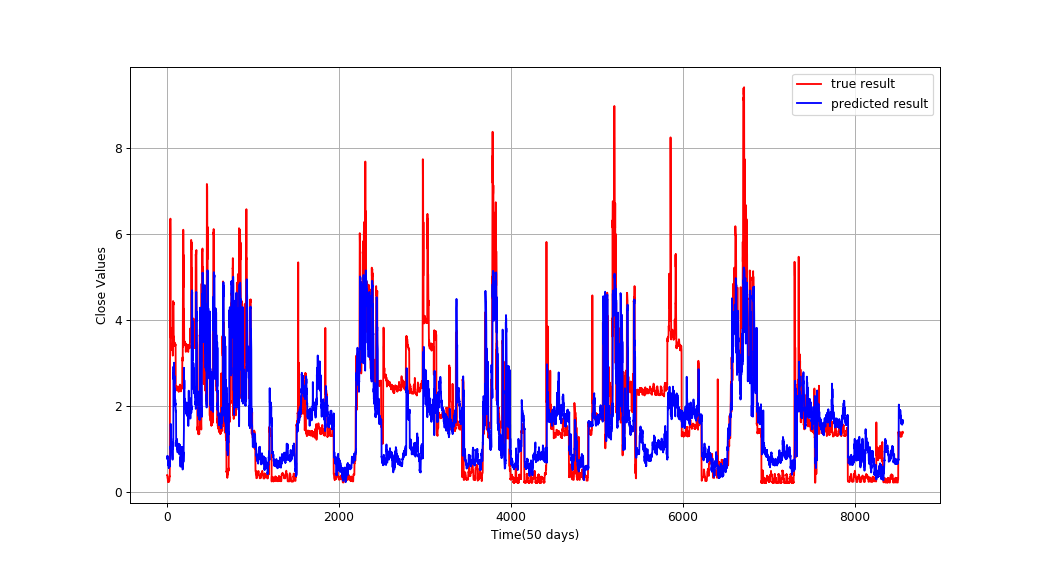

In [77]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_test,color="r",label="true result")
plt.plot(predict,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [78]:
mean_absolute_error(y_pred=predict, y_true=y_test)

0.7266893782166677

In [79]:
y_test.min()

0.206

In [80]:
predict.min()

0.22459438

In [81]:
mean_squared_error(y_pred=predict, y_true=y_test)

0.996154824563016